<a href="https://colab.research.google.com/github/KhuramC/SoftwareTutorials/blob/main/Dendrite_Length_Constant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This lab will be used to introduce you to multicompartmental models and introduce you to Cable Theory illustrated by a passive dendrite.

In [14]:
!pip install neuron

Installing neuron to simulate the dendrite and necesssary packages to plot graphs.

In [15]:
from neuron import h
import matplotlib.pyplot as plt
import numpy as np

In [16]:
h.load_file('stdrun.hoc')

1.0

# Defining dendrite geometry
The dendrite is defined here as a cylinder with given diameter and length. It is then divided into a given amount of segments that are evenly-lengthed.

In [17]:
dendrite = h.Section('dendrite') # create neuron Section hoc object
diam = 2 # micrometer
length = 10000 # micrometer
dendrite.pt3dadd(0,0,0,diam) # (x,y,z,diam) add 3d coordinate
dendrite.pt3dadd(length,0,0,diam) # (x,y,z,diam)
print("Dendrite length = " + str(dendrite.L) +  " micrometers")
print("Dendrite diameter = " + str(dendrite.diam) + " micrometers")
dendrite.nseg = 400 # number of evenly-lengthed, computational compartments per section (segments are compartments that divide up the entire section)

Dendrite length = 10000.0 micrometers
Dendrite diameter = 2.0 micrometers


# Visualization of Dendrite

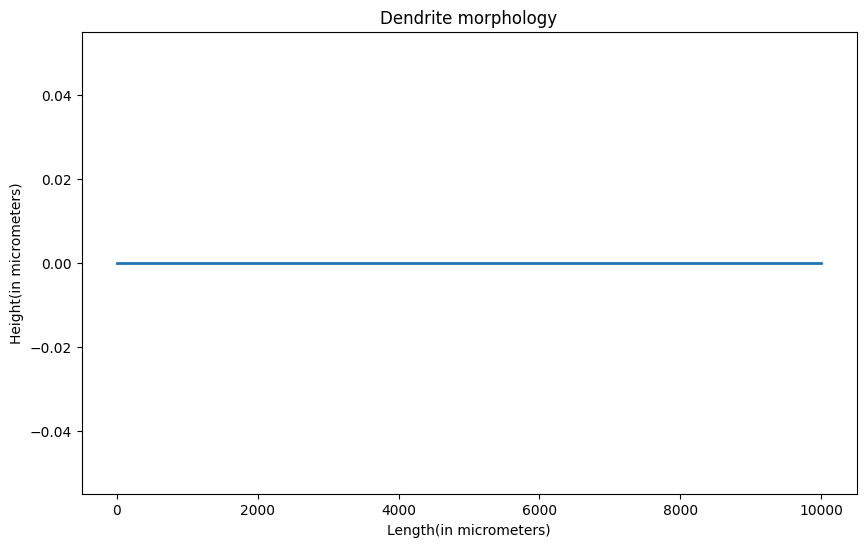

In [18]:
xcoords=[]
ycoords=[]
for i_3d in range(dendrite.n3d()): # for 3d coordinate index in range(number of 3d coordinates)
  xcoords.append(dendrite.x3d(i_3d)) # print x3d coordinate
  ycoords.append(dendrite.y3d(i_3d))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(xcoords, ycoords, linewidth= dendrite.diam)

# Add title and labels
plt.title('Dendrite morphology')
plt.xlabel('Length(in micrometers)')
plt.ylabel('Height(in micrometers)')

# Show the plot
plt.show()

# Defining Biophysics(Channels/Conductance...)
Here we add only passive leak channels, define its reversal potential and capcitance.
Anything not explicitly defined(like the leak channel conductance and axial resitivity) is defined to NEURON's default values(more on these default values and making a model can be found [here](http://web.mit.edu/neuron_v7.4/nrntuthtml/tutorial/tutA.html)).

In [19]:
# define axon membrane biophysics
dendrite.insert('pas') # passive channel

dendrite.e_pas = -70 # reveral potential mV (resting membrane potential in passive case)
dendrite.cm = 1 # membrane capacitance uF/cm2


# define leak conductance, axons are myelinated and have much less leak.
#dendrite.g_pas = (0.0003) #default value for leak channel S/cm2
#dendrite.Ra = 250 # axial resistivity ohm-cm

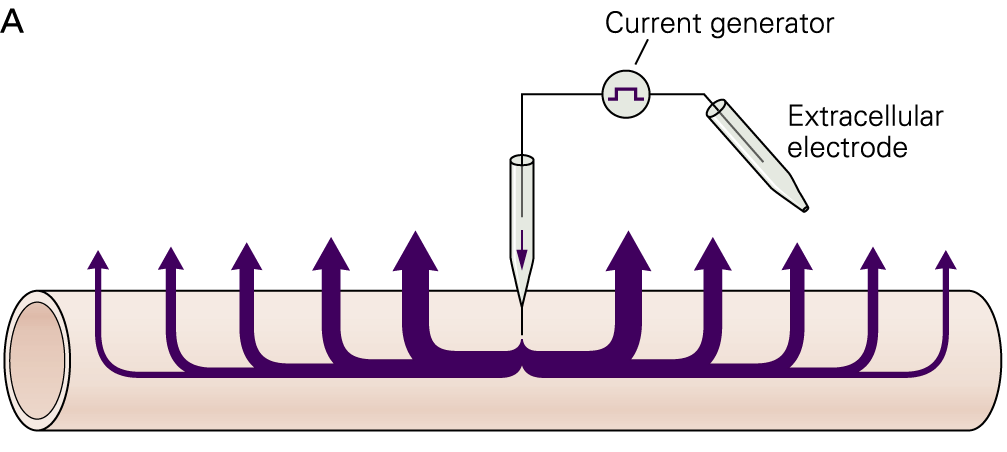
# Voltage Clamp
We want to voltage clamp the middle of the dendrite so that it spreads evenly on both sides. We will be injecting -10 mV for 1000ms.

In [20]:
# Voltage clamp halfway through the dendrite
vc = h.VClamp(dendrite(0.5)) # create hoc voltage clamp object halfway

vc.dur[0]=1000 # ms

vc.amp[0]=-10 # mV

# Simulation Parameters
Here we define the starting voltages, how long the simulation is, and do some recording of voltages throughout the simulation, and then run it.

In [ ]:
# define simulation parameters
h.tstop = tstop = 1000 # how long to run the simulation in ms
h.dt = 0.025 # time step (resolution) of the simulation in ms
h.v_init = dendrite.e_pas # give v(0) = e_leak


# record the voltage (_ref_v) and time (_ref_t) into the vectors we just created
V_vecs = [] # list of voltage vectors
for seg in dendrite:
  seg_V_vec = h.Vector() # define vector object for recording variable
  seg_V_vec.record(seg._ref_v) # record simulated voltage into vector
  V_vecs.append(seg_V_vec)

t_vec = h.Vector() # time vector
t_vec.record(h._ref_t) # record time during simulation

h.run() # run simulation

# Plotting Voltage
This graphs the steady state voltage through injection. Notice that it is symmetrical and exponential.

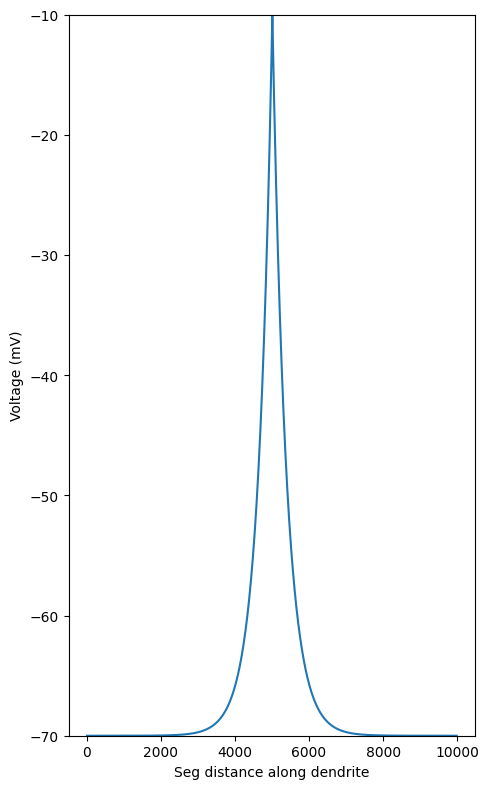

In [22]:
fig, ax = plt.subplots(figsize=(5, 8))

t = int(200/h.dt)  # time index to plot

x_values = [seg.x*dendrite.L for seg in dendrite]
y_values = [V_vecs[i][t] for i, seg in enumerate(dendrite)]

ax.plot(x_values, y_values)

ax.set_xlabel('Seg distance along dendrite')
ax.set_ylabel('Voltage (mV)')
ax.set_ylim(-70, vc.amp[0])

plt.tight_layout()
plt.show()

# Calculating Length Constant: 2 methods

#1. Analytically
Using the properties of the cable: membrane resistivity and intracellular resistivity

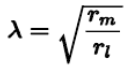

$$
\lambda = \sqrt(\frac{r_m}{r_l})
$$

Length constant = unit membrane resistance / unit axial resistance
in ohms / m.


$$
r_m = \frac{R_m}{2a\pi}
$$
Where Rm is the membrane resistance of unit area(in ohm * m^2), and a is the radius of the of the dendrite(in m).

In [23]:
# calculate length constant from membrane resistance and axial resistance
Rm = 1/dendrite.g_pas # ohm / cm^2
Rm_in_m = Rm / 10000 # convert to ohm / m^2
radius_in_m = (dendrite.diam / 2) / 1000000 # convert um to m
rm = Rm_in_m / (2 * np.pi * radius_in_m) # rm = Rm / (2 * pi * radius) # ohm / m

$$
r_l = \frac{p_l}{a^2π}
$$
Where a is the radius of the dendrite(in m) and pl is the axial resistivity(in ohm * m).

In [24]:
Ra_in_m = dendrite.Ra / 100 # convert ohm-cm to ohm-m
ra = Ra_in_m / (np.pi * (radius_in_m)**2) #ra = Ra / (pi * radius^2) # ohm / m
length_constant = np.sqrt(rm / ra) #plug into the formula
length_constant = round(length_constant,4)
print("Lambda = " + str(length_constant) + " m") #in millimeters

Lambda = 0.0004 m


#2.Experimentally
Using the simulation's values for voltage solving for the distance away from the center.

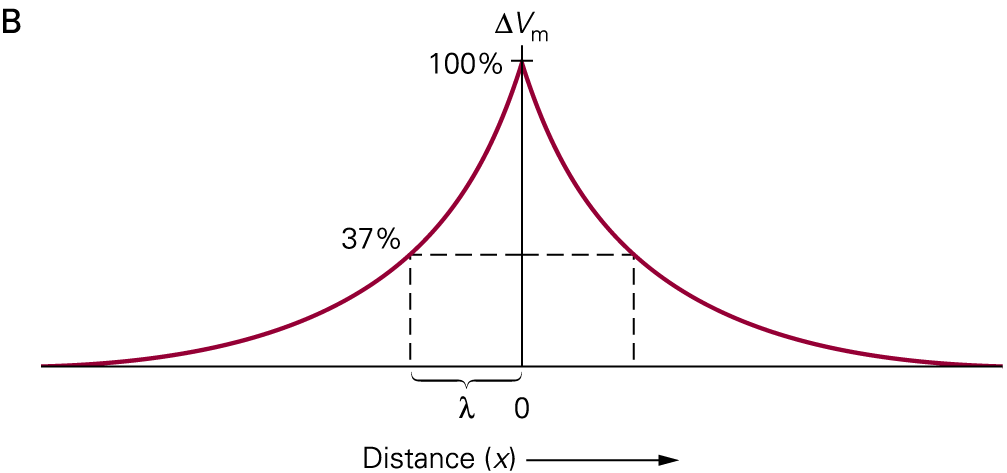

Length constant is where 63% of the voltage change has occurred, so we can just find the voltage(the y value) and then solve to find distance(the x value) away from the center it is, which is the length constant.

In [25]:
import math
V0 = vc.amp[0] #max is where we are putting in the current, i.e. -10mV
Vsteady = dendrite.e_pas #the steady is when there is no current leaking, i.e. -70mV, or the resting membrane potential.
deltav = V0 - Vsteady #the change in V is the difference between the two, i.e. 60 mV
dv = deltav /math.e # 37% of the change
Vx = Vsteady + dv # add to get where we are at 37% of the
#print(Vx)
distance = 0
diffray = []
for i in range(len(V_vecs)):                #this goes over every segment to find out where the voltage is closest to the Vx we want
  diffray.append(abs(Vx - max(V_vecs[i])))
minindex = diffray.index(min(diffray))

for i,seg in enumerate(dendrite):
  if(i == minindex):
    #print(f"maximum V at {seg} ({seg.x*dendrite.L} away from 0):{max(V_vecs[i])} mv")
    distance = seg.x*dendrite.L
#the length_constant is the distance between the Vx and the middle of the axon(where the current is being injected), so we need account for that
length_constant = abs(distance - (dendrite.L/2))
#rounding + converting from micrometers to meters.
length_constant_in_m = length_constant/(10**6)
#then going back to millimeters and rounding
print("Lambda  = " + str(round(length_constant_in_m, 4)) + " m")



Lambda  = 0.0004 m
